In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch
import torchvision

In [2]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class ExtractDataset(Dataset):
    def __init__(self,filename) -> None:
        file_data = pd.read_csv(filename)
        
        x = file_data.iloc[:,1:].values
        y = file_data.iloc[:,0].values

        
        x_train = x/255.0
        y_train = y

        self.X = torch.tensor(x_train , dtype=torch.float32)
        self.y = torch.tensor(y_train)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index) :
        return self.X[index],self.y[index]



In [5]:
ex = ExtractDataset('data/train.csv')

In [6]:
train_loader = torch.utils.data.DataLoader(ex,batch_size = 64,shuffle=True)

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)

In [8]:
examples = enumerate(train_loader)
print("batch_idx, (example_data, example_targets) = next(examples)")
print(next(examples)[1][0].shape)


batch_idx, (example_data, example_targets) = next(examples)
torch.Size([64, 1, 28, 28])


In [9]:
next(examples)

(1,
 [tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            ...,
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
  
  
          [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            ...,
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
            [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
  
  
          [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.

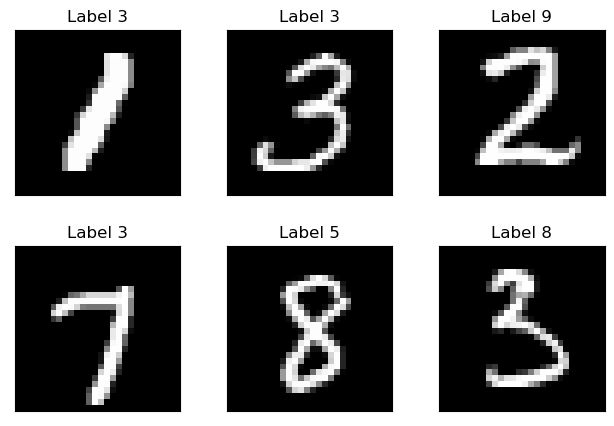

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(6): 
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(next(examples)[1][0][i].reshape(28,28),cmap="gray")
    plt.title(f"Label {next(examples)[1][1][i]}")
    plt.xticks([])
    plt.yticks([])


In [11]:
class NeuralNet(nn.Module):
    def __init__(self) -> None:
        super(NeuralNet,self).__init__()

        self.conv = nn.Conv2d(1,28,kernel_size=3) #[28,1,3,3] -[out_ch,in_ch,k_h,k_w]
        self.pool = nn.MaxPool2d(2)

        self.hidden = nn.Linear(4732,128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128,10)

    def forward(self,x): # [64, 1, 28, 28] - [batchsize,n_channel,height,weight]
        
        x = self.relu(self.conv(x)) # [64,28,26,26]
        x = self.pool(x) # [64,28,13,13]
        x = x.view(x.size(0),-1) # [64,28x13x13]
        x = self.relu(self.hidden(x))
        # x = nn.Dropout(0.2)(x)
        x = F.dropout(x, training=self.training)
        x = self.relu(self.output(x))

        return x


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
model = Net()
# model.to(torch.device('cuda'))
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [14]:
train_losses = []
train_counter = []

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [16]:
for epoch in range(1,n_epochs+1):
    train(epoch)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/var/folders/zx/mhdl9f0d1c552plym17cmqym0000gn/T/ipykernel_23941/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336324
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287670
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.284852
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.277154
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.278713
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223541
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.233047
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.214941
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.154417
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.118175
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.054808
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.955404
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.984716
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.831533
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.633135
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.528579
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.477398
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.273704
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.187052
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.157796
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.328065
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.210802
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.205242
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.406868
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.405864
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.626250
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.292639
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.558835
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.167156
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.212270
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.296405
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.198359
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.453653
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.275895
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.299541
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.254634
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.307786
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.411380
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.384804
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.348971


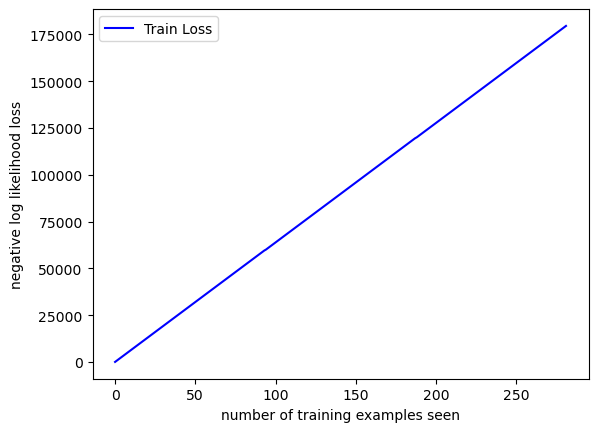

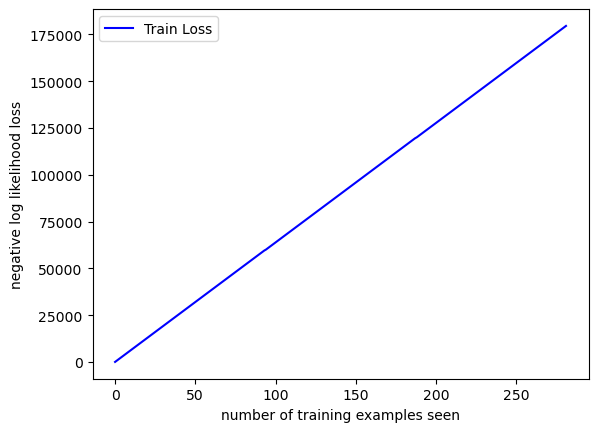

In [17]:
fig = plt.figure()
plt.plot(train_counter, color='blue')
plt.legend(['Train Loss'])
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [18]:
ex = ExtractDataset('data/test.csv')
test_loader = torch.utils.data.DataLoader(ex,batch_size = 64,shuffle=True)

In [19]:
examples = enumerate(test_loader)
print("batch_idx, (example_data, example_targets) = next(examples)")
print(next(examples)[1][0].shape)


batch_idx, (example_data, example_targets) = next(examples)
torch.Size([64, 783])


In [20]:
import pandas as pd
test_data =pd.read_csv("data/test.csv")

In [21]:
test_data_1 = test_data.iloc[0,:].values.reshape(1,784)

In [22]:
data=torch.from_numpy(test_data_1)
data = data.type(torch.float64)
# test_loader = torch.utils.data.DataLoader(data,batch_size = 64,shuffle=True)

In [23]:
data = enumerate(test_loader)

In [24]:
with torch.no_grad():
    output = model(data)

TypeError: conv2d() received an invalid combination of arguments - got (enumerate, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!enumerate!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!enumerate!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [25]:
output

NameError: name 'output' is not defined

In [26]:
import pickle
with open("model.pkl","wb") as f:
    pickle.dump(model,f)

In [27]:
import matplotlib.pyplot as plt
import cv2

arr = cv2.imread('image.png',cv2.IMREAD_UNCHANGED)

In [28]:
arr.shape

(600, 600)

In [29]:
resized_image = cv2.resize(arr, (28, 28),interpolation=cv2.INTER_LINEAR)/255.0
# resized_image = resized_image.astype("float64")
data = torch.from_numpy(resized_image)
data.type('torch.DoubleTensor')
# data.to(torch.float32)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [30]:
stretch_near.shape

NameError: name 'stretch_near' is not defined

In [31]:
plt.imshow(stretch_near,cmap="gray")

NameError: name 'stretch_near' is not defined

In [32]:
data

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [33]:
with torch.no_grad():
    output = model(data)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [28, 28]

In [34]:
data.shape

torch.Size([28, 28])